# Inference and Validation

In [24]:
%matplotlib inline
%config InLineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import numpy as np
import time
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import helper

In [25]:
# Load and transform dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

# Download and load training
trainset = datasets.FashionMNIST("F_MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load test
testset = datasets.FashionMNIST("F_MNIST_data/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Building the network

In [26]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        '''Build a feedforward network with arbitrary hidden layers
        
        Args
        --------
        input_size: int, size of input
        output_size: int, size of output layer
        hidden_layers: list of int, the size of each hidden layer
        drop_p: float between 0-1, dropout probability
        '''
        
        super().__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Variable number of hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p=drop_p)
    
    def forward(self, x):
        '''Feedforward pass through the network, returns the output logits'''
        # Forward through each layer in hidden layers, ReLU activation
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [27]:
# Create the network, define criterion and optimizer
model = Network(784, 10, [516, 256], drop_p=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        images.resize_(images.shape[0], 784)
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

In [29]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40
for epoch in range(epochs):
    model.train()
    for images, labels in trainloader:
        steps += 1
        
        # Flatten the image into 1D vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
       
        if steps % print_every == 0:
            model.eval()
            with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
            print("""
            Epoch: {}/{}.. Training Loss: {:.3f}.. Test Loss: {:.3f}.. Test Accuracy: {:.2f}
            """ .format(epoch+1, epochs, running_loss/print_every, test_loss/len(testloader), accuracy/len(testloader)))
        running_loss = 0
        model.train()


            Epoch: 1/2.. Training Loss: 0.026.. Test Loss: 0.785.. Test Accuracy: 0.71
            

            Epoch: 1/2.. Training Loss: 0.018.. Test Loss: 0.651.. Test Accuracy: 0.76
            

            Epoch: 1/2.. Training Loss: 0.013.. Test Loss: 0.629.. Test Accuracy: 0.76
            

            Epoch: 1/2.. Training Loss: 0.019.. Test Loss: 0.581.. Test Accuracy: 0.79
            

            Epoch: 1/2.. Training Loss: 0.016.. Test Loss: 0.546.. Test Accuracy: 0.80
            

            Epoch: 1/2.. Training Loss: 0.018.. Test Loss: 0.560.. Test Accuracy: 0.79
            

            Epoch: 1/2.. Training Loss: 0.014.. Test Loss: 0.538.. Test Accuracy: 0.80
            

            Epoch: 1/2.. Training Loss: 0.018.. Test Loss: 0.536.. Test Accuracy: 0.80
            

            Epoch: 1/2.. Training Loss: 0.016.. Test Loss: 0.526.. Test Accuracy: 0.81
            

            Epoch: 1/2.. Training Loss: 0.015.. Test Loss: 0.513.. Test Accuracy: 0.81
   

# Inference

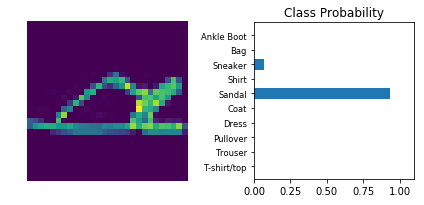

In [31]:
# Test the network
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

# Convert 2D to 1D
img = img.view(1, 784)

# Calculate probs (softmax)
with torch.no_grad():
    output = model.forward(img)
    
ps = torch.exp(output)

helper.view_classify(img.view(1, 28, 28), ps, version="Fashion")